In [211]:
# import modules
import pandas as pd
import numpy as np
from WindPy import w
import matplotlib.pyplot as plt
import datetime as dt


In [212]:
# main variables
stock_name = 'AAPL.O'
start_date = '2021-01-01'
startdate = dt.date(2021,1,1)
end_date = '2022-10-14'
enddate = dt.date(2022,10,14)
pred_end_date = '2022-11-15'
pred_enddate = dt.date(2022, 11, 15)
scen_size = 1000
w.start()


.ErrorCode=0
.Data=[Already conntected!]

In [25]:
# download and prepare data
prices = w.wsd(stock_name, "close", start_date, pred_end_date, "TradingCalendar=NASDAQ")


In [27]:
price = prices
price

.ErrorCode=0
.Codes=[AAPL.O]
.Fields=[CLOSE]
.Times=[20210104,20210105,20210106,20210107,20210108,20210111,20210112,20210113,20210114,20210115,...]
.Data=[[129.41,131.01,126.6,130.92,132.05,128.98,128.8,130.89,128.91,127.14,...]]

In [213]:
prices = pd.DataFrame(price.Data,columns=price.Times)
prices = prices.transpose()
train_set = prices[:enddate]
test_set = prices[enddate:pred_enddate]
daily_returns = ((train_set / train_set.shift(periods=1)) - 1)[0][1:]

## SDE Equation reference
https://en.wikipedia.org/wiki/Geometric_Brownian_motion



In [214]:
# Geometric Brownian Motion (GBM)
 

# Parameter Assignments
So = train_set.iloc[-1][0] #initial stock price
dt = 1  # day   # User input; time increment
n_of_wkdays = pd.date_range(start=pd.to_datetime(end_date,
                                                 format="%Y-%m-%d") + pd.Timedelta('1 days'),
                            end=pd.to_datetime(pred_end_date,
                                               format="%Y-%m-%d")).to_series().map(lambda x: 1 if x.isoweekday() in range(1, 6) else 0).sum()
T = n_of_wkdays #length of the prediction time horizon(how many time points to predict, same unit with dt(days))
N = T / dt # number of time points in prediction the time horizon -> T/dt
t = np.arange(1, int(N) + 1) #array for time points in the prediction time horizon [1, 2, 3, .. , N]
mu = np.mean(daily_returns) # mean of historical daily returns
sigma = np.std(daily_returns.T) # standard deviation of historical daily returns
## Monte-Carlo Simulation
b = {str(scen): np.random.normal(0, 1, int(N)) for scen in range(1, scen_size + 1)} #array for brownian increments
W = {str(scen): b[str(scen)].cumsum() for scen in range(1, scen_size + 1)} # array for brownian path




In [215]:
# Calculating drift and diffusion components
drift = (mu - 0.5 * sigma ** 2) * t
diffusion = {str(scen): sigma * W[str(scen)] for scen in range(1, scen_size + 1)}



In [216]:
# Making the predictions
S = np.array([So * np.exp(drift + diffusion[str(scen)]) for scen in range(1, scen_size + 1)])
S = np.hstack((np.array([[So] for scen in range(scen_size)]), S))  # add So to the beginning series
S_max = [S[:, i].max() for i in range(0, int(N))]
S_min = [S[:, i].min() for i in range(0, int(N))]
S_pred = .5 * np.array(S_max) + .5 * np.array(S_min)
final_df = pd.DataFrame(data=[test_set.reset_index()[0], S_pred],
                        index=['real', 'pred']).T
final_df.index = test_set.index
mse = 1/len(final_df) * np.sum((final_df['pred'] - final_df['real']) ** 2)



In [217]:
final_df

,real,pred
2022-10-14,138.38,138.380000
2022-10-17,142.41,139.474227
2022-10-18,143.75,139.875405
2022-10-19,143.86,139.623388
2022-10-20,143.39,140.152116
2022-10-21,147.27,140.352016
2022-10-24,149.45,138.221496
2022-10-25,152.34,139.169549
2022-10-26,149.35,140.432825
2022-10-27,144.80,141.838268


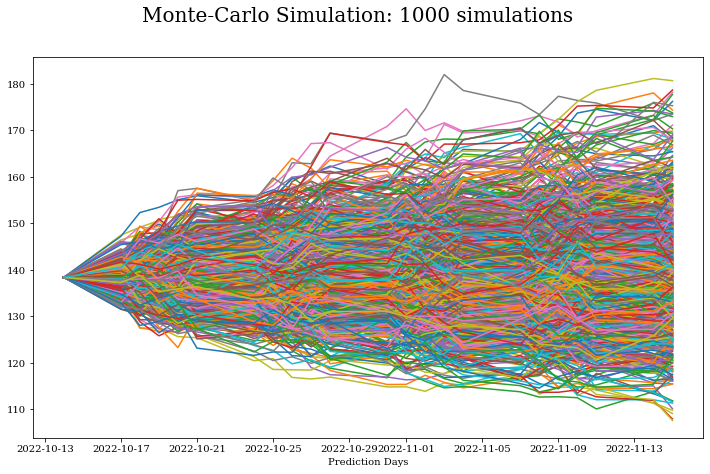

In [224]:
# Plotting the simulations
# plt.rcParams["font.family"] = "serif"
# fig, ax = plt.subplots()
plt.figure(figsize=(12,7))
plt.suptitle('Monte-Carlo Simulation: ' + str(scen_size) + ' simulations', fontsize=20)
plt.xlabel('Prediction Days')
for i in range(scen_size):
    plt.plot(pd.date_range(start=train_set.index[-1],
                           end=pred_end_date,
                           freq='D').map(lambda x: x if x.isoweekday() in range(1, 6) else np.nan).dropna(), S[i, :])
plt.show()



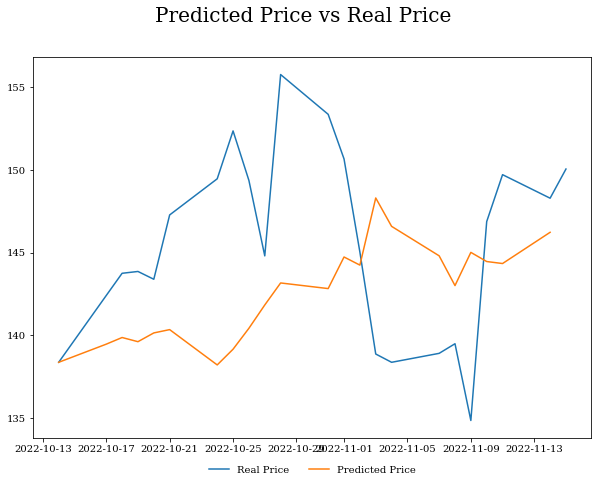

In [226]:
# Plotting the final prediction against the real price
plt.figure(figsize=(10,7))
plt.suptitle('Predicted Price vs Real Price', fontsize=20)
plt.plot(final_df)
plt.legend(['Real Price', 'Predicted Price'],
           loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2, frameon=False)
plt.show()